# California house price prediction using SVM regressor

Using the California housing dataset lets train and tune up an SVM regressor pipeline. and check if SVR pipeline statistically significantly better than randomforests?

For information on the dataset see [here](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html)

* This dataset consists of 20,640 samples and 9 features.


## Download data and do EDA

Let's load the dataset using Scikit-Learn's `fetch_california_housing()` function:

In [95]:
from sklearn.datasets import fetch_california_housing
import pandas as pd

housing = fetch_california_housing()
X = housing["data"]
y = housing["target"]

dfy=pd.DataFrame(y, columns=['target'])

In [96]:
housing.DESCR

'California housing dataset.\n\nThe original database is available from StatLib\n\n    http://lib.stat.cmu.edu/datasets/\n\nThe data contains 20,640 observations on 9 variables.\n\nThis dataset contains the average house value as target variable\nand the following input variables (features): average income,\nhousing average age, average rooms, average bedrooms, population,\naverage occupation, latitude, and longitude in that order.\n\nReferences\n----------\n\nPace, R. Kelley and Ronald Barry, Sparse Spatial Autoregressions,\nStatistics and Probability Letters, 33 (1997) 291-297.\n\n'

In [97]:
housing.feature_names

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

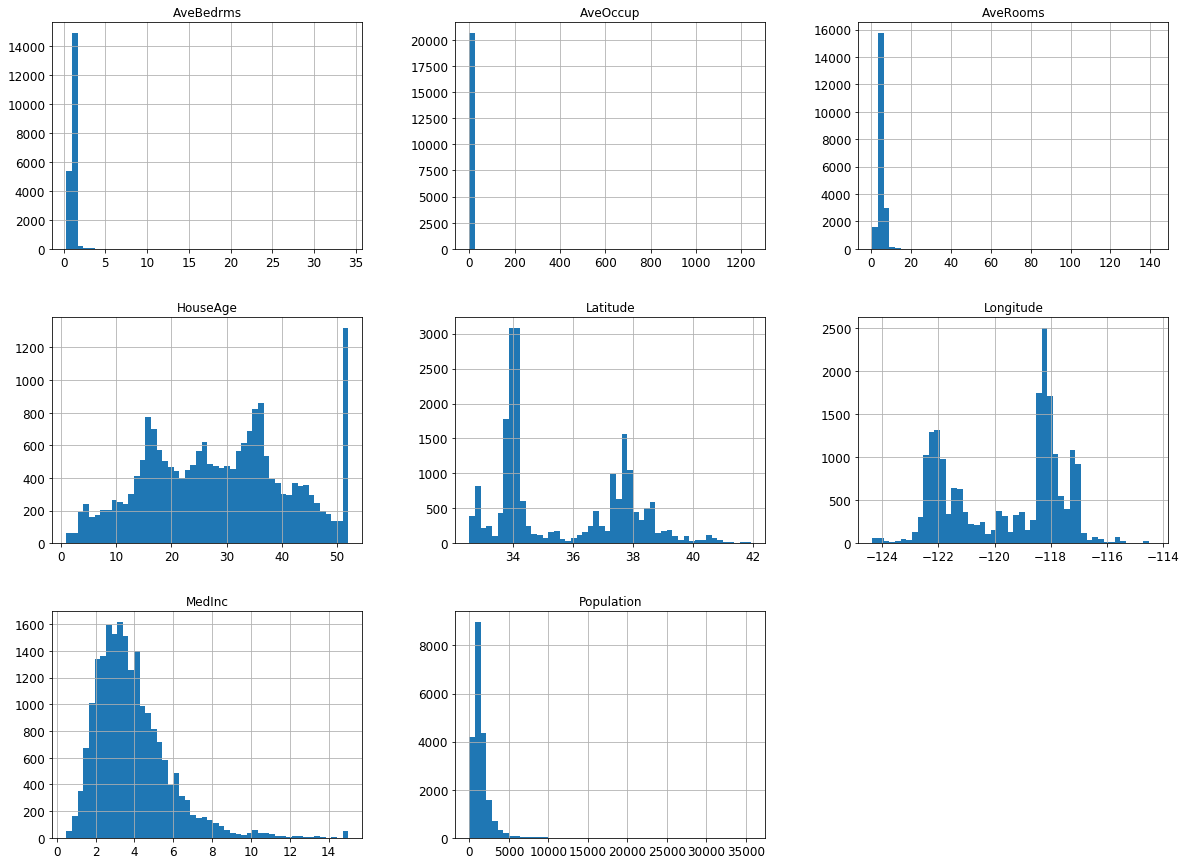

In [98]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
import pandas as pd
import numpy as np

df=pd.DataFrame(X, columns=housing.feature_names)
df.hist(bins=50, figsize=(20,15))
plt.show()

In this training set, the targets are hundreds of thousands of dollars. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000201F8DBFFD0>]], dtype=object)

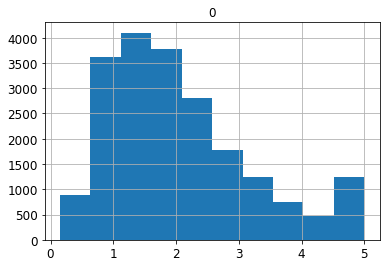

In [99]:
# Plot Target variable
# Target variable has been scaled by $100,000
pd.DataFrame(y).hist()

Split it into a training set and a test set:

In [100]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Stratified sampling

Perform stratified sampling based upon a categorical variable (that is derived from the data in this case). The derived vsariable is income_cat

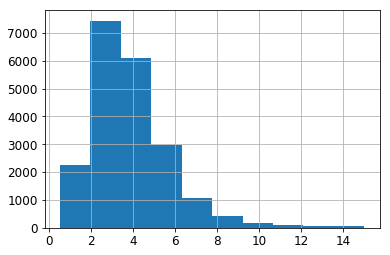

In [9]:
df['MedInc'].hist()

In [12]:
# Divide by 1.5 to limit the number of income categories
df["IncCat"] = np.ceil(df["MedInc"] / 1.5)
# Label those above 5 as 5
df["IncCat"].where(df["IncCat"] < 5, 5.0, inplace=True)

In [13]:
df["IncCat"].value_counts()

3.0    7236
2.0    6581
4.0    3639
5.0    2362
1.0     822
Name: IncCat, dtype: int64

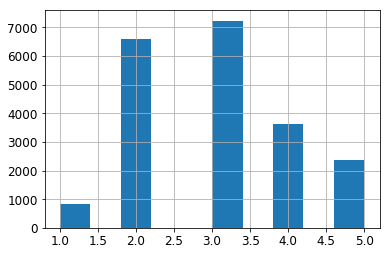

In [14]:
df["IncCat"].hist()

### Stratified train test split based on the distribution of Income Category

In [ ]:
dfn = df
dfn['target'] = dfy['target']
dfn.head()

In [30]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(dfn, dfn["IncCat"]):
    strat_train_set = dfn.loc[train_index]
    strat_test_set = dfn.loc[test_index]

In [31]:
df["IncCat"].value_counts() / len(df)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: IncCat, dtype: float64

### Exploratory Data Analysis

#### Visualize location of data sample

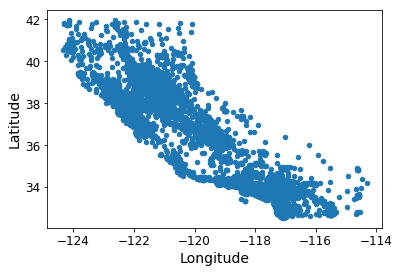

In [32]:
dfn.plot(kind="scatter", x="Longitude", y="Latitude")

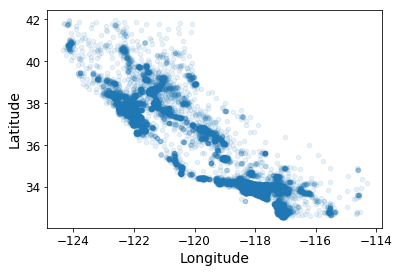

In [33]:
dfn.plot(kind="scatter", x="Longitude", y="Latitude", alpha=0.1)

#### District's population vs price

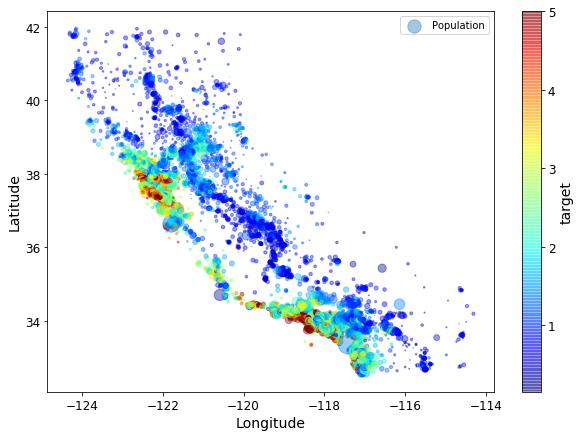

In [34]:
dfn.plot(kind="scatter", x="Longitude", y="Latitude", alpha=0.4,
    s=df["Population"]/100, label="Population", figsize=(10,7),
    c="target", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()

#### Correlation of the features with target 

In [36]:
corr_matrix = dfn.corr()
corr_matrix["target"].sort_values(ascending=False)

target        1.000000
MedInc        0.688075
IncCat        0.643892
AveRooms      0.151948
HouseAge      0.105623
AveOccup     -0.023737
Population   -0.024650
Longitude    -0.045967
AveBedrms    -0.046701
Latitude     -0.144160
Name: target, dtype: float64

C:\Users\Devi\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000201E8CE8208>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x00000201EA5ADC50>]], dtype=object)

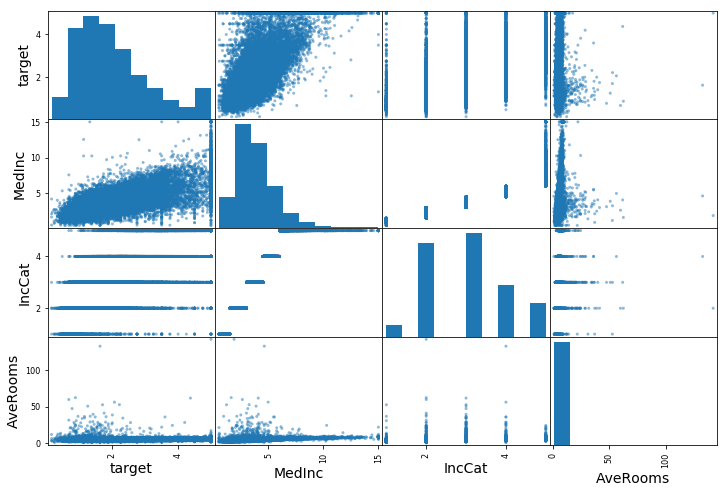

In [38]:
from pandas.tools.plotting import scatter_matrix

# Top three correlated inputs with housing_median_age
attributes = ["target", "MedInc", "IncCat",
              "AveRooms"]
scatter_matrix(dfn[attributes], figsize=(12, 8))


### Most correlated input feature with target variable

[0, 15, 0, 8]

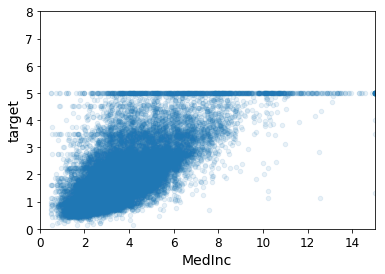

In [47]:
dfn.plot(kind="scatter", x="MedInc", y="target",
             alpha=0.1)
plt.axis([0, 15, 0, 8])

## Build a baseline pipeline

Scale the data and use pipeline.

In [101]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Let's train a simple `LinearSVR` first:

In [102]:
from sklearn.svm import LinearSVR

lin_svr = LinearSVR(random_state=42)
lin_svr.fit(X_train_scaled, y_train)

LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=42, tol=0.0001, verbose=0)

Let's see how it performs on the training set:

In [53]:
from sklearn.metrics import mean_squared_error
import numpy as np

y_pred = lin_svr.predict(X_train_scaled)
mse = mean_squared_error(y_train, y_pred)
mse

0.96128066532972734

Let's look at the RMSE:

In [54]:
np.sqrt(mse)

0.9804492160890983

In this training set, the targets are tens of thousands of dollars. The RMSE gives a rough idea of the kind of error you should expect (with a higher weight for large errors): so with this model we can expect errors somewhere around $100,000. Not great.

### Baseline pipeline

In [103]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
from sklearn.svm import LinearSVR
import numpy as np
num_pipeline = Pipeline([
#        ('imputer', Imputer(strategy="median")), # - There are no missing values so imputer is not used
        ('std_scaler', StandardScaler()),
    ])


full_pipeline = Pipeline([
        ("preparation", num_pipeline),
        ("linear", LinearSVR(random_state = 42)),
        ])

In [66]:
#Baseline Pipeline to execute Linear SVR
t = time()
full_pipeline.fit(X_train, y_train)
trntimeb = time() - t

y_pred_SVR_tr = full_pipeline.predict(X_train)

mse_SVR_tr = mean_squared_error(y_train, y_pred_SVR_tr)
rmse_SVR_tr = np.sqrt(mse_SVR_tr)

print('Train MSE for Linear SVR in pipeline: ', mse_SVR_tr)
print('Train RMSE for Linear SVR in pipeline: ', rmse_SVR_tr)

t = time()
y_pred_SVR = full_pipeline.predict(X_test)
tsttimeb = time() - t

mse_SVR = mean_squared_error(y_test, y_pred_SVR)
rmse_SVR = np.sqrt(mse_SVR)

print('Test MSE for Linear SVR in pipeline: ', mse_SVR)
print('Test RMSE for Linear SVR in pipeline: ', rmse_SVR)

Train MSE for Linear SVR in pipeline:  0.96128066533
Train RMSE for Linear SVR in pipeline:  0.980449216089
Test MSE for Linear SVR in pipeline:  0.581601891136
Test RMSE for Linear SVR in pipeline:  0.762628278479


## Tune hyperparameters of SVR
Let's see if we can do better with an RBF Kernel. We will use randomized search with cross validation to find the appropriate hyperparameter values for `C` and `gamma`:

In [104]:
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

param_distributions = {"gamma": reciprocal(20, 200000), "C": uniform(loc=0, scale=4)}
rnd_search_cv = RandomizedSearchCV(SVR(), param_distributions, n_iter=10, verbose=2, random_state=42)
rnd_search_cv.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] C=1.49816047539, gamma=127024.420213 ............................
[CV] ............. C=1.49816047539, gamma=127024.420213, total= 1.1min
[CV] C=1.49816047539, gamma=127024.420213 ............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s


[CV] ............. C=1.49816047539, gamma=127024.420213, total= 1.0min
[CV] C=1.49816047539, gamma=127024.420213 ............................
[CV] ............. C=1.49816047539, gamma=127024.420213, total= 1.1min
[CV] C=2.92797576725, gamma=4962.08194974 ............................
[CV] ............. C=2.92797576725, gamma=4962.08194974, total= 1.0min
[CV] C=2.92797576725, gamma=4962.08194974 ............................
[CV] ............. C=2.92797576725, gamma=4962.08194974, total= 1.1min
[CV] C=2.92797576725, gamma=4962.08194974 ............................
[CV] ............. C=2.92797576725, gamma=4962.08194974, total= 1.2min
[CV] C=0.62407456177, gamma=84.1410790058 ............................
[CV] ............. C=0.62407456177, gamma=84.1410790058, total=  21.2s
[CV] C=0.62407456177, gamma=84.1410790058 ............................
[CV] ............. C=0.62407456177, gamma=84.1410790058, total=  20.1s
[CV] C=0.62407456177, gamma=84.1410790058 ............................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 27.7min finished


RandomizedSearchCV(cv=None, error_score='raise',
          estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000201ECA51F98>, 'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000201EAA26898>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [70]:
rnd_search_cv.best_estimator_

SVR(C=3.329770563201687, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma=141.37949901249203, kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)

Now let's measure the RMSE on the training set:

In [71]:
y_pred = rnd_search_cv.best_estimator_.predict(X_train_scaled)
mse = mean_squared_error(y_train, y_pred)
np.sqrt(mse)

0.098118008500068424

Looks much better than the linear model. Let's select this model and evaluate it on the test set:

In [72]:
y_pred = rnd_search_cv.best_estimator_.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
np.sqrt(mse)

1.1388240125600237

In [75]:
rnd_search_cv.best_params_

{'C': 3.329770563201687, 'gamma': 141.37949901249203}

## Contrast with a random forest with 100 decision trees with a depth of 10.

In [65]:
#Random forest with 100 decision trees and depth 10
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV


#Standardize data through numerical pipeline
X_train_prep = num_pipeline.fit_transform(X_train)
X_test_prep = num_pipeline.fit_transform(X_test)

t = time()
forest_reg = RandomForestRegressor(random_state=42, n_estimators=100, max_depth=10)
forest_reg.fit(X_train_prep, y_train)
trntime1 = time() - t 

y_pred_RF_tr = forest_reg.predict(X_train_prep)
mse_RF_tr = mean_squared_error(y_train, y_pred_RF_tr)
rmse_RF_tr = np.sqrt(mse_RF_tr)

print('Train MSE for Random Forest : ', mse_RF_tr)
print('Train RMSE for Random Forest: ', rmse_RF_tr)

t = time()
y_pred_RF = forest_reg.predict(X_test_prep)
tsttime1 = time() - t


mse_RF = mean_squared_error(y_test, y_pred_RF)
rmse_RF = np.sqrt(mse_RF)

print('Test MSE for Random Forest : ', mse_RF)
print('Test RMSE for Random Forest: ', rmse_RF)

Train MSE for Random Forest :  0.171219811536
Train RMSE for Random Forest:  0.413787157288
Test MSE for Random Forest :  0.637482101392
Test RMSE for Random Forest:  0.798424762512


In [64]:
#Decision Treee with depth 10 - This is not asked in the assignment but I tried by myself to check how Decision treee performs for this data
from sklearn.tree import DecisionTreeRegressor

X_train_prep = num_pipeline.fit_transform(X_train)
X_test_prep = num_pipeline.fit_transform(X_test)

t = time()
tree_reg = DecisionTreeRegressor(random_state=42, max_depth=10)
tree_reg.fit(X_train_prep, y_train)
trntime2 = time() - t

y_pred_tree_tr = tree_reg.predict(X_train_prep)
mse_tree_tr = mean_squared_error(y_train, y_pred_tree_tr)
rmse_tree_tr = np.sqrt(mse_tree_tr)

print('Train MSE for Random Forest : ', mse_tree_tr)
print('Train RMSE for Random Forest: ',rmse_tree_tr)

t = time()
y_pred_tree = tree_reg.predict(X_test_prep)
tsttime2 = time() - t

mse_tree = mean_squared_error(y_test, y_pred_tree)
rmse_tree = np.sqrt(mse_tree)

print('Test MSE for Random Forest : ', mse_tree)
print('Test RMSE for Random Forest: ',rmse_tree)

Train MSE for Random Forest :  0.220865791205
Train RMSE for Random Forest:  0.469963606255
Test MSE for Random Forest :  0.958094262839
Test RMSE for Random Forest:  0.978822896565


### Significance Testing

In [84]:
#Statistics significance testing between baseline LinearSVR and Random Forest
from scipy import stats
from sklearn.model_selection import cross_val_score
#from sklearn.tree import DecisionTreeRegressor
#from sklearn.linear_model import LinearRegression

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

# A sampling based bakeoff using *K-fold cross-validation*: 
# it randomly splits the training set into K distinct subsets (k=30)
# this bakeoff framework can be used for regression or classification
#Control system is a linear regression based pipeline

kFolds=30

SVCreg = LinearSVR()
SVC_scores = cross_val_score(SVCreg, X_train_scaled, y_train,
                             scoring='neg_mean_squared_error', cv=kFolds)
control = SVC_rmse_scores = np.sqrt(-SVC_scores)
display_scores(SVC_rmse_scores)

for_reg = RandomForestRegressor(random_state=42, n_estimators=100, max_depth=10)
for_scores = cross_val_score(for_reg, X_train_scaled, y_train,
                             scoring='neg_mean_squared_error', cv=kFolds)
treatment = for_rmse_scores = np.sqrt(-for_scores)
display_scores(for_rmse_scores)

#paired t-test; two-tailed p-value (aka two-sided)
(t_score, p_value) = stats.ttest_rel(control, treatment)
print("The p-value is %0.5f for a t-score of %0.5f." %(p_value, t_score))
#"The p-value is 0.00019 for a t-score of -4.28218." 
if p_value > 0.05/2:  #Two sided 
    print('There is no significant difference between the two machine learning pipelines (Accept H0)')
else:
    print('The two machine learning pipelines are different (reject H0) \n(t_score, p_value) = (%.2f, %.5f)'%(t_score, p_value) )
    if t_score < 0.0:
        print('Machine learning pipeline A is better than B')
    else:
        print('Machine learning pipeline B is better than A')

Scores: [ 0.69416564  0.70775217  0.670192    0.70841853  0.81454115  0.75372022
  0.97627178  0.69684776  0.74310259  0.73169746  0.669942    0.6903903
  0.67213023  0.77306621  0.76136759  0.72557983  7.15762294  0.69860192
  2.48088864  0.6629647   0.67764093  0.68591551  0.77625879  0.75078032
  0.72920065  0.73874408  2.00885532  0.74277741  0.73320166  0.76843758]
Mean: 1.04670253057
Standard deviation: 1.19871745499
Scores: [ 0.54671501  0.52287447  0.49456999  0.50535993  0.59869054  0.56956238
  0.58845037  0.47899604  0.52822071  0.54246483  0.53612513  0.54737156
  0.4824629   0.57813754  0.58719271  0.49871866  0.54656326  0.50845827
  0.54920429  0.50054055  0.49600438  0.49397588  0.56482708  0.57900829
  0.52334364  0.52431756  0.53876176  0.55772503  0.52836409  0.54434441]
Mean: 0.535378375795
Standard deviation: 0.032723213898
The p-value is 0.02860 for a t-score of 2.30375.
There is no significant difference between the two machine learning pipelines (Accept H0)


In [105]:
#Statistics significance testing between baseline SVR with RBF kernel and Random Forest
from scipy import stats
from sklearn.model_selection import cross_val_score
#from sklearn.tree import DecisionTreeRegressor
#from sklearn.linear_model import LinearRegression

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

# A sampling based bakeoff using *K-fold cross-validation*: 
# it randomly splits the training set into K distinct subsets (k=30)
# this bakeoff framework can be used for regression or classification
#Control system is a linear regression based pipeline

kFolds=30

SVRreg = rnd_search_cv.best_estimator_
SVR_scores = cross_val_score(SVRreg, X_train_scaled, y_train,
                         scoring="neg_mean_squared_error", cv=kFolds)
control = SVR_rmse_scores = np.sqrt(-SVR_scores)
display_scores(SVR_rmse_scores)

for_reg = RandomForestRegressor(random_state=42, n_estimators=100, max_depth=10)
for_scores = cross_val_score(for_reg, X_train_scaled, y_train,
                             scoring="neg_mean_squared_error", cv=kFolds)
treatment = for_rmse_scores = np.sqrt(-for_scores)
display_scores(for_rmse_scores)

#paired t-test; two-tailed p-value (aka two-sided)
(t_score, p_value) = stats.ttest_rel(control, treatment)
print("The p-value is %0.5f for a t-score of %0.5f." %(p_value, t_score))
#"The p-value is 0.00019 for a t-score of -4.28218." 
if p_value > 0.05/2:  #Two sided 
    print('There is no significant difference between the two machine learning pipelines (Accept H0)')
else:
    print('The two machine learning pipelines are different (reject H0) \n(t_score, p_value) = (%.2f, %.5f)'%(t_score, p_value) )
    if t_score < 0.0:
        print('Machine learning pipeline A is better than B')
    else:
        print('Machine learning pipeline B is better than A')

Scores: [ 1.13918028  1.19172356  1.12260966  1.1081754   1.24083842  1.17629193
  1.14053575  1.12497978  1.18071064  1.12291059  1.11557906  1.11990132
  1.10067883  1.15996298  1.18732412  1.1841528   1.18314164  1.12565064
  1.15173798  1.08703231  1.16739226  1.14216326  1.13603396  1.14091178
  1.16303343  1.16418776  1.15514114  1.14514221  1.13861662  1.21437732]
Mean: 1.15100391471
Standard deviation: 0.0335860642055
Scores: [ 0.54671501  0.52287447  0.49456999  0.50535993  0.59869054  0.56956238
  0.58845037  0.47899604  0.52822071  0.54246483  0.53612513  0.54737156
  0.4824629   0.57813754  0.58719271  0.49871866  0.54656326  0.50845827
  0.54920429  0.50054055  0.49600438  0.49397588  0.56482708  0.57900829
  0.52334364  0.52431756  0.53876176  0.55772503  0.52836409  0.54434441]
Mean: 0.535378375795
Standard deviation: 0.032723213898
The p-value is 0.00000 for a t-score of 94.53338.
The two machine learning pipelines are different (reject H0) 
(t_score, p_value) = (94.53,

### Experimental Results

In [151]:
# Experimental Results
import pandas as pd

res = []
svm = ["4gb RAM", "1", rmse_SVR_tr, "N/A-Baseline", trntimeb, tsttimeb, "SVM algo. for baseline"]
res.append(svm)
svmtune = ["4gb RAM", "2", rmse_RF_tr, '0.02860', "NA-Randomsearch CV", "NA-Randomsearch CV", "SVC RBF - Tuning"]
res.append(svmtune)
forest = ["4gb RAM", "2", "0.09811", '0.0000', trntime1, tsttime1, "Random forest - pair test with SVC RBF"]
res.append(forest)
res

results = pd.DataFrame(res, columns=["Hardware", "ExpID", "RMSE", "p-value", "TrainTime(s)", "TestTime(s)", "Experiment description"])

print('**')
results

**


,Hardware,ExpID,RMSE,p-value,TrainTime(s),TestTime(s),Experiment description
0,4gb RAM,1,0.980449,N/A-Baseline,2.13052,0.00100136,SVM algo. for baseline
1,4gb RAM,2,0.413787,0.02860,NA-Randomsearch CV,NA-Randomsearch CV,SVC RBF - Tuning
2,4gb RAM,2,0.09811,0.0000,11.3291,0.0700517,Random forest - pair test with SVC RBF


Based on the above results the Random forest alogirthm performs significantly better than SVC with RBF kernel. The train and test time also looks pretty desecnet so Random forest is the right choice for the California housing data we picked.